In [1]:
import os
from joblib import Parallel, delayed

import numpy as np
import scipy as sc
import matplotlib.pyplot as plt
from tqdm import tqdm

from src.CPQAOA import CP_QAOA
from src.QAOA import QAOA
from src.Grid import Grid
from src.Chain import Chain
from src.Tools import (portfolio_metrics, 
                       min_cost_partition, 
                       get_qubo, 
                       normalized_cost, 
                       qubo_limits, 
                       check_qubo,
                       partitioned_averages)

# INITIAL TEST RUNS:

In [86]:
# Number of Qubits 
N=12
# Number of excitations
k=6
# RNG seed for reproducibility
seed=1
# alpha in: s^T*mu + alpha*(s^T*Covar*s)
alpha=0.5
# Nr. of layer repetitions
layers=5
# Maximal number of iterations for classical solver
max_iter=6000
# Using next nearest neighbors (in 1D chain model)
w_next_nearest_neighbors = True





In [87]:
my_chain = Chain(N_qubits=N)
print(f' Qubit indices in chain: \n', my_chain.get_chain_indexing())
print(f'\n Corresponding Nearest Neighbor index pairs: \n', my_chain.get_NN_indices())
print(f'\n Corresponding Nearest Neighbor + Next Nearest index pairs: \n', my_chain.get_NNN_indices())
init_strat = np.array([0,1,0,1,0,1,0,1,0,1,0,1])
my_chain.set_initialization_strategy(strategy=init_strat)
print(f'\n Initialization strategy is: \n', my_chain.get_initialization_strategy())
print(f'\n Corresponding indices is: \n', my_chain.get_initialization_indices())

 Qubit indices in chain: 
 [ 0  1  2  3  4  5  6  7  8  9 10 11]

 Corresponding Nearest Neighbor index pairs: 
 [(0, 1), (1, 2), (2, 3), (3, 4), (4, 5), (5, 6), (6, 7), (7, 8), (8, 9), (9, 10), (10, 11)]

 Corresponding Nearest Neighbor + Next Nearest index pairs: 
 [(0, 1), (0, 2), (1, 2), (1, 3), (2, 3), (2, 4), (3, 4), (3, 5), (4, 5), (4, 6), (5, 6), (5, 7), (6, 7), (6, 8), (7, 8), (7, 9), (8, 9), (8, 10), (9, 10), (9, 11)]

 Initialization strategy is: 
 [0 1 0 1 0 1 0 1 0 1 0 1]

 Corresponding indices is: 
 [1, 3, 5, 7, 9, 11]


In [88]:
my_grid = Grid(Rows=3,Cols=4)
print(f' Qubit indices in grid: \n', my_grid.get_grid_indexing())
print(f'\n Corresponding Nearest Neighbor index pairs: \n', my_grid.get_NN_indices())
print(f'\n Corresponding Nearest Neighbor + Next Nearest index pairs: \n', my_grid.get_NNN_indices())
init_strat = np.array([[0,1,0,1],
                       [1,0,1,0],
                       [0,1,0,1]])
my_grid.set_initialization_strategy(strategy=init_strat)
print(f'\n Initialization strategy is: \n', my_grid.get_initialization_strategy())
print(f'\n Corresponding indices is: \n', my_grid.get_initialization_indices())

 Qubit indices in grid: 
 [[ 0  1  2  3]
 [ 4  5  6  7]
 [ 8  9 10 11]]

 Corresponding Nearest Neighbor index pairs: 
 [(0, 4), (0, 1), (1, 5), (1, 2), (2, 6), (2, 3), (3, 7), (4, 8), (4, 5), (5, 9), (5, 6), (6, 10), (6, 7), (7, 11), (8, 9), (9, 10), (10, 11)]

 Corresponding Nearest Neighbor + Next Nearest index pairs: 
 [(0, 4), (0, 1), (1, 5), (1, 2), (2, 6), (2, 3), (3, 7), (4, 8), (4, 5), (5, 9), (5, 6), (6, 10), (6, 7), (7, 11), (8, 9), (9, 10), (10, 11), (0, 8), (0, 2), (1, 9), (1, 3), (2, 10), (3, 11), (4, 6), (5, 7), (8, 10), (9, 11)]

 Initialization strategy is: 
 [[0 1 0 1]
 [1 0 1 0]
 [0 1 0 1]]

 Corresponding indices is: 
 [1, 3, 4, 6, 9, 11]


In [89]:
# Deciding between grid and 1d chain topology
my_topology = my_chain

In [90]:
# Generating random problem instance 
expected_returns, covariances = portfolio_metrics(n=N, seed=seed)

# Retrieving C_min, C_max and corresponding states for original portfolio problem
constrained_result, full_result, lmbda = min_cost_partition(nr_qubits=N,
                                                            k=k,
                                                            mu=expected_returns,
                                                            sigma=covariances,
                                                            alpha=alpha)

portfolio_subspace_max_cost, portfolio_subspace_min_cost, portfolio_subspace_min_state = constrained_result['c_max'], constrained_result['c_min'], constrained_result['s']
full_space_max_cost = full_result['c_max']
portfolio_subspace_min_state_str = ''.join([str(_) for _ in portfolio_subspace_min_state])
print(f"Min. cost portfolio (constrained subspace): {portfolio_subspace_min_cost}")
print("Optimal portfolio state (constrained subspace) is: |"+portfolio_subspace_min_state_str+">")

Min. cost portfolio (constrained subspace): 38.34467168415999
Optimal portfolio state (constrained subspace) is: |110100000111>


In [91]:

# Generating QUBO corresponding to current problem instance
Q, offset = get_qubo(mu=expected_returns,
                     sigma=covariances, 
                     alpha=alpha,
                     lmbda=lmbda+1e-8, # Adding small constant purposely
                     k=k)
QUBO_limits = qubo_limits(Q=Q,offset=offset)
qubo_min_cost, qubo_max_cost = QUBO_limits['c_min'], QUBO_limits['c_max']
qubo_min_state, qubo_max_state = QUBO_limits['min_state'], QUBO_limits['max_state']
check_qubo(QUBO_matrix=Q, QUBO_offset=offset, expected_returns=expected_returns, covariances=covariances, alpha=alpha, k=k)
qubo_min_state_str = ''.join([str(_) for _ in qubo_min_state])
print(f"Min. cost QUBO: {qubo_min_cost}")
print("Min. cost QUBO state is: |"+qubo_min_state_str+">")


Min. cost QUBO: 38.34467168415995
Min. cost QUBO state is: |110100000111>


In [1]:
print("Check that qubo min cost is same as portfolio min cost:")
qubo_min_cost, portfolio_subspace_min_cost

Check that qubo min cost is same as portfolio min cost:


NameError: name 'qubo_min_cost' is not defined

In [93]:
print("Check that qubo max cost is at least portfolio max cost:")
qubo_max_cost, portfolio_subspace_max_cost

Check that qubo max cost is at least portfolio max cost:


(1589.1346145659952, 69.42020191316345)

In [94]:
# Generating instances of ansatz'
CP_ansatz = CP_QAOA(N_qubits=N,
                 cardinality=k,
                 layers=layers,
                 topology=my_topology,
                 QUBO_matrix=Q,
                 with_next_nearest_neighbors=w_next_nearest_neighbors,
                 with_z_phase=False)

CP_z_phase_ansatz = CP_QAOA(N_qubits=N,
                 cardinality=k,
                 layers=layers,
                 topology=my_topology,
                 QUBO_matrix=Q,
                 with_next_nearest_neighbors=w_next_nearest_neighbors,
                 with_z_phase=True)

NORMAL_ansatz = QAOA(N_qubits=N,
                     layers=layers,
                     QUBO_matrix=Q,
                     QUBO_offset=offset)

In [95]:
"""# Generating initial guess for rotation angles for CP_ansatz
theta_min, theta_max = -2*np.pi, 2*np.pi
N_angles = layers * len(my_topology.get_NN_indices())
if w_next_nearest_neighbors:
    N_angles += layers * (N - 2)
CP_theta_i = np.random.uniform(low=theta_min, high=theta_max, size=N_angles)
print(f"CP: {len(CP_theta_i)}")"""

# Choosing optimizer for scipy
available_methods = ['COBYLA', 'Nelder-Mead']
optimizer_method = available_methods[0]

# Generating callback function for plotting
CP_costs = [] # Normalized costs
CP_probs = [] # probability of optimal state
"""def CP_callback_function(x):
    _dict_ = CP_ansatz.get_state_probabilities(flip_states=False)
    # N.B. Normalizing w. respect to full space max cost
    _cost_ = normalized_cost(result=_dict_,
                             QUBO_matrix=Q,
                             QUBO_offset=offset,
                             max_cost=qubo_max_cost, 
                             min_cost=qubo_min_cost)
    if portfolio_subspace_min_state_str in list(_dict_.keys()):
        CP_probs.append(_dict_[portfolio_subspace_min_state_str])
    else:
        CP_probs.append(0)
    CP_costs.append(_cost_)

"""
# Performing optimization
"""CP_res = sc.optimize.minimize(fun=CP_ansatz.get_cost, x0=CP_theta_i,
                           method=optimizer_method,
                           options={'disp': False, 'maxiter': max_iter},
                           callback=CP_callback_function)"""


# Generating callback function for plotting
CP_z_phase_costs = [] # Normalized costs
CP_z_phase_probs = [] # probability of optimal state
def CP_z_phase_callback_function(x):
    _dict_ = CP_z_phase_ansatz.get_state_probabilities(flip_states=False)
    # N.B. Normalizing w. respect to full space max cost
    _cost_ = normalized_cost(result=_dict_,
                             QUBO_matrix=Q,
                             QUBO_offset=offset,
                             max_cost=qubo_max_cost, 
                             min_cost=qubo_min_cost)
    if portfolio_subspace_min_state_str in list(_dict_.keys()):
        CP_z_phase_probs.append(_dict_[portfolio_subspace_min_state_str])
    else:
        CP_z_phase_probs.append(0)
    CP_z_phase_costs.append(_cost_)

# Generating initial guess for rotation angles for CP_ansatz
theta_min, theta_max = -2*np.pi, 2*np.pi
N_angles = layers * len(my_topology.get_NN_indices())
if w_next_nearest_neighbors:
    N_angles += layers * len(my_topology.get_NNN_indices())
N_angles += layers * N # Because this is WITH Z-phase
CP_z_phase_theta_i = np.random.uniform(low=theta_min, high=theta_max, size=N_angles)
print(f"CP+Z-PHASE: {len(CP_z_phase_theta_i)}")
# Performing optimization
CP_z_phase_res = sc.optimize.minimize(fun=CP_z_phase_ansatz.get_cost, x0=CP_z_phase_theta_i,
                           method=optimizer_method,
                           options={'disp': False, 'maxiter': max_iter},
                           callback=CP_z_phase_callback_function)




"""# For normal QAOA w. need "layers" nr. of angles for both 'beta' and 'gamma'
N_angles = 2 * layers 
NORMAL_theta_i = np.random.uniform(low=theta_min, high=theta_max, size=N_angles)
print(f"QAOA: {len(NORMAL_theta_i)}")"""

# Generating callback function for plotting
NORMAL_costs = [] # Normalized costs
NORMAL_probs = [] # probability of optimal state
"""def NORMAL_callback_function(x):
    _dict_ = NORMAL_ansatz.get_state_probabilities(flip_states=False)
    # N.B. Normalizing w. respect to full space max cost
    _cost_ = normalized_cost(result=_dict_,
                             QUBO_matrix=Q,
                             QUBO_offset=offset,
                             max_cost=qubo_max_cost, 
                             min_cost=qubo_min_cost)
    if portfolio_subspace_min_state_str in list(_dict_.keys()):
        NORMAL_probs.append(_dict_[portfolio_subspace_min_state_str])
    else:
        NORMAL_probs.append(0)
    NORMAL_costs.append(_cost_)"""


"""NORMAL_res = sc.optimize.minimize(fun=NORMAL_ansatz.get_cost, x0=NORMAL_theta_i,
                           method=optimizer_method,
                           options={'disp': False, 'maxiter': max_iter},
                           callback=NORMAL_callback_function)"""

CP+Z-PHASE: 215


"NORMAL_res = sc.optimize.minimize(fun=NORMAL_ansatz.get_cost, x0=NORMAL_theta_i,\n                           method=optimizer_method,\n                           options={'disp': False, 'maxiter': max_iter},\n                           callback=NORMAL_callback_function)"

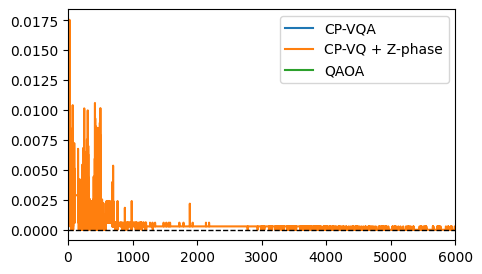

In [96]:
# N.B. Because the normalization is done w. respect to the "allowed states (w. k ones)" QAOA has cost above 1.
fig, ax = plt.subplots(1,1, figsize=(5,3))
ax.plot([it for it in range(len(CP_costs))], CP_costs, label='CP-VQA')
ax.plot([it for it in range(len(CP_z_phase_costs))], CP_z_phase_costs, label='CP-VQ + Z-phase')
ax.plot([it for it in range(len(NORMAL_costs))], NORMAL_costs, label='QAOA')
ax.set_xlim(0,max(len(CP_costs),len(NORMAL_costs), len(CP_z_phase_costs)))
#ax.set_ylim(-0.1,1.1)
ax.hlines(0,0,max(len(CP_costs),len(NORMAL_costs), len(CP_z_phase_costs)),lw=1,linestyles='dashed',colors='k')
ax.legend(loc='upper right')
plt.show()

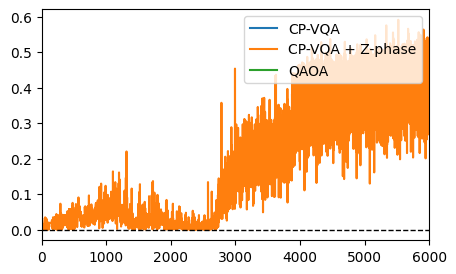

In [97]:
fig, ax = plt.subplots(1,1, figsize=(5,3))
ax.plot([it for it in range(len(CP_probs))], CP_probs, label='CP-VQA')
ax.plot([it for it in range(len(CP_z_phase_probs))], CP_z_phase_probs, label='CP-VQA + Z-phase')
ax.plot([it for it in range(len(NORMAL_probs))], NORMAL_probs, label='QAOA')
ax.set_xlim(0,max(len(CP_probs),len(NORMAL_probs), len(CP_z_phase_probs)))
#ax.set_ylim(-0.1,1.1)
ax.hlines(0,0,max(len(CP_probs),len(NORMAL_probs), len(CP_z_phase_probs)),lw=1,linestyles='dashed',colors='k')
ax.legend(loc='upper right')
plt.show()

# TRYING OVER MULTIPLE LAYERS (AVG. OVER MULTIPLE SEEDS):

In [5]:
def simulate(datapoint):
    N,k,alpha,max_iter,my_topology,w_nnn,seed,N_layers = datapoint
    
    # Generating random problem instance 
    expected_returns, covariances = portfolio_metrics(n=N, seed=seed)
    
    # Retrieving C_min, C_max and corresponding states.
    constrained_result, full_result, lmbda = min_cost_partition(nr_qubits=N,
                                                                k=k,
                                                                mu=expected_returns,
                                                                sigma=covariances,
                                                                alpha=alpha)
    
    portfolio_subspace_max_cost, portfolio_subspace_min_cost, portfolio_subspace_min_state = constrained_result['c_max'], constrained_result['c_min'], constrained_result['s']
    portfolio_subspace_min_state_str = ''.join([str(_) for _ in portfolio_subspace_min_state])
    
    # Generating QUBO corresponding to current problem instance
    Q, offset = get_qubo(mu=expected_returns,
                         sigma=covariances,
                         alpha=alpha,
                         lmbda=lmbda+1e-8,
                         k=k)
    
    QUBO_limits = qubo_limits(Q=Q,offset=offset)
    qubo_min_cost, qubo_max_cost = QUBO_limits['c_min'], QUBO_limits['c_max']
    qubo_min_state, qubo_max_state = QUBO_limits['min_state'], QUBO_limits['max_state']
    check_qubo(QUBO_matrix=Q, QUBO_offset=offset, expected_returns=expected_returns, covariances=covariances, alpha=alpha, k=k)
    qubo_min_state_str = ''.join([str(_) for _ in qubo_min_state])
    
    if not portfolio_subspace_min_state_str == qubo_min_state_str:
        raise RuntimeError(f'portfolio_subspace_min_state_str: {portfolio_subspace_min_state_str}, qubo_min_state_str={qubo_min_state_str}'+f'Min. cost of qubo is: {qubo_min_cost}, but min. cost of constrained portfolio is: {portfolio_subspace_min_cost}.')
    
    if not np.isclose(qubo_min_cost,portfolio_subspace_min_cost):
        raise RuntimeError(f'Min. cost of qubo is: {qubo_min_cost}, but min. cost of constrained portfolio is: {portfolio_subspace_min_cost}.')
    
    if not qubo_max_cost >= portfolio_subspace_max_cost:
        raise RuntimeError(f'Max. cost of qubo: {qubo_max_cost}, max. cost of portfolio subspace: {portfolio_subspace_max_cost} (should be qubo max. >= constrained portfolio max)')
    
    # Defining method for scipy optimizer
    optimizer_method = 'COBYLA'
    
    # Generating instances of ansatz'
    CP_z_phase_ansatz = CP_QAOA(N_qubits=N,
                     cardinality=k,
                     layers=N_layers,
                     topology=my_topology,
                     QUBO_matrix=Q,
                     with_next_nearest_neighbors=w_nnn,
                     with_z_phase=True)
    
    
    # Generating callback function for plotting
    CP_z_phase_costs = [] # Normalized costs
    CP_z_phase_probs = [] # probability of optimal state
    def CP_z_phase_callback_function(x):
        _dict_ = CP_z_phase_ansatz.get_state_probabilities(flip_states=False)
        # N.B. Normalizing w. respect to full space max cost
        _cost_ = normalized_cost(result=_dict_,
                                 QUBO_matrix=Q,
                                 QUBO_offset=offset,
                                 max_cost=qubo_max_cost, 
                                 min_cost=qubo_min_cost)
        if portfolio_subspace_min_state_str in list(_dict_.keys()):
            CP_z_phase_probs.append(_dict_[portfolio_subspace_min_state_str])
        else:
            CP_z_phase_probs.append(0)
        CP_z_phase_costs.append(_cost_)
    
    # Generating initial guess for rotation angles for CP_ansatz
    theta_min, theta_max = -2*np.pi, 2*np.pi
    N_angles = N_layers * len(my_topology.get_NN_indices())
    if w_next_nearest_neighbors:
        N_angles += N_layers * (N - 2)
    N_angles += N_layers * N # Because this is WITH Z-phase
    CP_z_phase_theta_i = np.random.uniform(low=theta_min, high=theta_max, size=N_angles)
    # Performing optimization
    CP_z_phase_res = sc.optimize.minimize(fun=CP_z_phase_ansatz.get_cost, x0=CP_z_phase_theta_i,
                               method=optimizer_method,
                               options={'disp': False, 'maxiter': max_iter},
                               callback=CP_z_phase_callback_function)
    
    
    return {'(N,k,alpha,max_iter,my_topology,w_nnn,seed,N_layers)': datapoint,
            'CP_VQA_Z_PHASE': (CP_z_phase_probs, CP_z_phase_costs, CP_z_phase_res)}


In [6]:
# Number of Qubits 
N_vals = [4,6,9,12]
# alpha in: s^T*mu + alpha*(s^T*Covar*s)
alpha=0.5
# Maximal number of iterations for classical solver
max_iter=1000
# Using next nearest neighbors (in 1D chain model)
w_next_nearest_neighbors = False
# Number of layer repetitions
N_layers = 3


initialization_strategies = [np.array([[0,1],
                                       [1,0]]),
                             
                             np.array([[0,1,0],
                                       [1,0,1]]),
                             
                             np.array([[0,1,0],
                                       [1,0,1],
                                       [0,1,0]]),
                             
                             np.array([[0,1,0,1],
                                       [1,0,1,0],
                                       [0,1,0,1]])]

row_cols = [(2,2),
            (2,3),
            (3,3),
            (3,4)]

N_SEEDS = 100
N_jobs = os.cpu_count()-1

datapoints = []
for seed in range(N_SEEDS):
    n_counter = 0
    for N in N_vals:
        k = N // 2
        my_topology = Grid(Rows=row_cols[n_counter][0],Cols=row_cols[n_counter][1])
        my_topology.set_initialization_strategy(strategy=initialization_strategies[n_counter])
        dp = (N,k,alpha,max_iter,my_topology,w_next_nearest_neighbors,seed,N_layers)
        datapoints.append(dp)
        n_counter += 1
        
r = Parallel(n_jobs=N_jobs, verbose=51, backend='loky')(delayed(simulate)(datapoint) for datapoint in datapoints)

[Parallel(n_jobs=7)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=7)]: Done   1 tasks      | elapsed:   19.3s
[Parallel(n_jobs=7)]: Done   2 tasks      | elapsed:   19.4s
[Parallel(n_jobs=7)]: Done   3 tasks      | elapsed:   28.4s
[Parallel(n_jobs=7)]: Done   4 tasks      | elapsed:   30.1s
[Parallel(n_jobs=7)]: Done   5 tasks      | elapsed:   37.8s
[Parallel(n_jobs=7)]: Done   6 tasks      | elapsed:   46.0s
[Parallel(n_jobs=7)]: Done   7 tasks      | elapsed:   46.1s
[Parallel(n_jobs=7)]: Done   8 tasks      | elapsed:   51.1s
[Parallel(n_jobs=7)]: Done   9 tasks      | elapsed:  1.0min
[Parallel(n_jobs=7)]: Done  10 tasks      | elapsed:  1.1min
[Parallel(n_jobs=7)]: Done  11 tasks      | elapsed:  1.2min
[Parallel(n_jobs=7)]: Done  12 tasks      | elapsed:  1.2min
[Parallel(n_jobs=7)]: Done  13 tasks      | elapsed:  1.4min
[Parallel(n_jobs=7)]: Done  14 tasks      | elapsed:  1.5min
[Parallel(n_jobs=7)]: Done  15 tasks      | elapsed:  1.5min
[Parallel(

In [8]:
result = {}
for N in N_vals:
    result[N] = {}
    result[N]['probs'] = []
    result[N]['costs'] = []
    
for run in r:
    N = run['(N,k,alpha,max_iter,my_topology,w_nnn,seed,N_layers)'][0]
    CP_z_phase_props, CP_z_phase_costs = run['CP_VQA_Z_PHASE'][0], run['CP_VQA_Z_PHASE'][1]
    result[N]['probs'].append(CP_z_phase_props[-1])
    result[N]['costs'].append(CP_z_phase_costs[-1])
    
CP_z_phase_probs_avgs, CP_z_phase_probs_std_devs = {}, {}
CP_z_phase_costs_avgs, CP_z_phase_costs_std_devs = {}, {}
for N in N_vals:
    CP_z_phase_probs_avgs[N]=np.mean(result[N]['probs'])
    CP_z_phase_probs_std_devs[N]=np.std(result[N]['probs'])
    
    CP_z_phase_costs_avgs[N]=np.mean(result[N]['costs'])
    CP_z_phase_costs_std_devs[N]=np.std(result[N]['costs'])


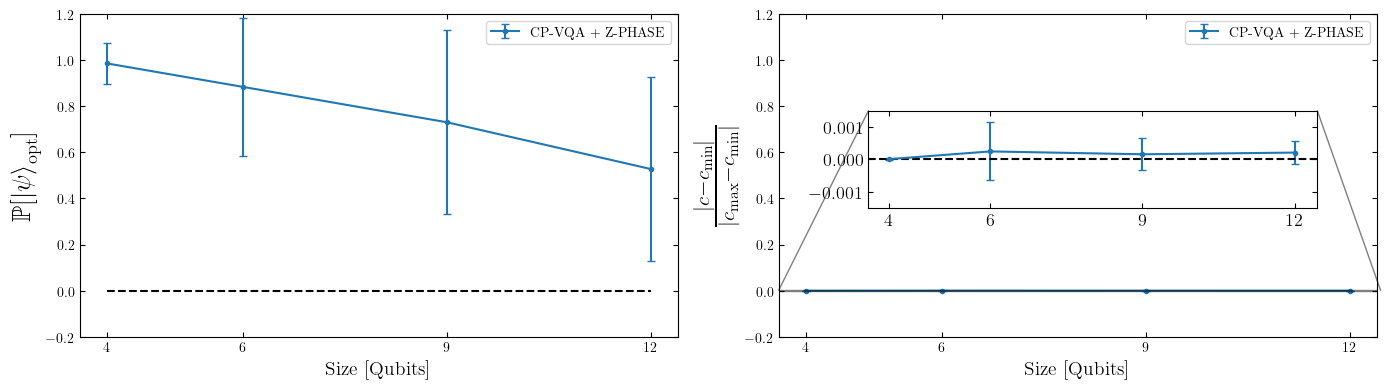

In [12]:
plt.rc("font", family=["Helvetica", "Arial"])
plt.rc("text", usetex=True)
plt.rcParams['text.latex.preamble'] = r'\usepackage{amsmath}\usepackage{amssymb}\usepackage{physics}'
plt.rc("xtick", top=True, direction="in")
plt.rc("ytick", right=True, direction="in")

fig, ax = plt.subplots(1,2,figsize=(14,4))
sizes = N_vals
ax[0].errorbar(sizes, [CP_z_phase_probs_avgs[N] for N in sizes],yerr=[CP_z_phase_probs_std_devs[N] for N in sizes], fmt='.-', capsize=3, label='CP-VQA + Z-PHASE')
ax[0].set_xticks(sizes)
ax[0].set_ylabel(r'$\mathbb{P}[\ket{\psi}_{\text{opt}}]$',size=19)
ax[0].set_ylim(-0.2,1.2)
ax[0].legend(loc='upper right')
ax[0].set_xlabel('Size [Qubits]',size=14)
ax[0].hlines(0,min(sizes),max(sizes),ls='--',color='k')

ax[1].errorbar(sizes, [CP_z_phase_costs_avgs[N] for N in sizes],yerr=[CP_z_phase_costs_std_devs[N] for N in sizes],fmt='.-', capsize=3, label='CP-VQA + Z-PHASE')
ax[1].set_xticks(sizes)
ax[1].set_ylim(-0.2,1.2)
ax[1].legend(loc='upper right')
ax[1].set_ylabel(r'$\frac{|c-c_{\textrm{min}}|}{|c_{\textrm{max}}-c_{\textrm{min}}|}$', size=22)
ax[1].set_xlabel('Size [Qubits]',size=14)

################## miniplot ##################
# inset axes....
axins_x_left, axins_y_lower, axins_x_width, axins_height = 0.15, 0.4, 0.75, 0.3
axins = ax[1].inset_axes([axins_x_left, axins_y_lower, axins_x_width, axins_height])
axins.errorbar(sizes, [CP_z_phase_costs_avgs[N] for N in sizes],yerr=[CP_z_phase_costs_std_devs[N] for N in sizes],fmt='.-', capsize=3, label='CP-VQA + Z-PHASE')
# sub region of the original image
x1, x2, y1, y2 = min(sizes)*0.9, max(sizes)*1.0375, -0.0015, 0.0015
axins.set_xlim(x1, x2)
axins.set_ylim(y1, y2)
axins.hlines(0, min(sizes)*0.9, max(sizes)*1.0375,ls='--',color='k')
axins.set_xticks(sizes)
axins.tick_params(axis='both', which='major', labelsize=13)
ax[1].indicate_inset_zoom(axins, edgecolor="black")

plt.tight_layout()

#plt.savefig('../figures/fig_6.png',dpi=300)
plt.show()

In [13]:
from typing import *

def partitioned_averages(unsorted_list: List[List[Union[int, float]]]) -> Tuple[List[float], List[float]]:
    # Sort the list of lists by their length (shortest first)
    sorted_list = sorted(unsorted_list, key=len)

    partitioned_avgs = []  # To store the partitioned averages
    partitioned_std_devs = []  # To store the partitioned std. devs.

    # Iterate over each sublist
    for l1 in range(len(sorted_list)):
        l1_length = len(sorted_list[l1])  # Length of the current sublist

        # Add corresponding elements from longer sublists and calculate partial averages
        _avg_ = [sorted_list[l1]]
        for l2 in range(l1 + 1, len(sorted_list)):
            _avg_.append(sorted_list[l2][:l1_length])
        _std_dev_ = np.std(np.array(_avg_).astype(float), axis=0)
        _avg_ = np.mean(np.array(_avg_).astype(float), axis=0)
        # Append the new elements of the average to the result
        if l1 > 0:
            partitioned_avgs.append(_avg_[len(sorted_list[l1 - 1]):])
            partitioned_std_devs.append(_std_dev_[len(sorted_list[l1 - 1]):])
        else:
            partitioned_avgs.append(_avg_)
            partitioned_std_devs.append(_std_dev_)

    # Combine all partitioned averages into a single list
    combined_avgs = []
    for avg_part in partitioned_avgs:
        combined_avgs += avg_part.tolist()
    combined_std_devs = []
    for std_dev_part in partitioned_std_devs:
        combined_std_devs += std_dev_part.tolist()

    return combined_avgs, combined_std_devs

In [14]:
result = {N: {'probs': {'CP_VQA_Z_PHASE': []},
              'costs': {'CP_VQA_Z_PHASE': []}} for N in N_vals}
for run in r:
    N = run['(N,k,alpha,max_iter,my_topology,w_nnn,seed,N_layers)'][0]
    CP_z_phase_props, CP_z_phase_costs = run['CP_VQA_Z_PHASE'][0], run['CP_VQA_Z_PHASE'][1]
    result[N]['probs']['CP_VQA_Z_PHASE'].append(CP_z_phase_props)
    result[N]['costs']['CP_VQA_Z_PHASE'].append(CP_z_phase_costs)

for N in N_vals:
    result[N]['probs']['CP_VQA_Z_PHASE'] = partitioned_averages(unsorted_list=result[N]['probs']['CP_VQA_Z_PHASE'])
    result[N]['costs']['CP_VQA_Z_PHASE'] = partitioned_averages(unsorted_list=result[N]['costs']['CP_VQA_Z_PHASE'])

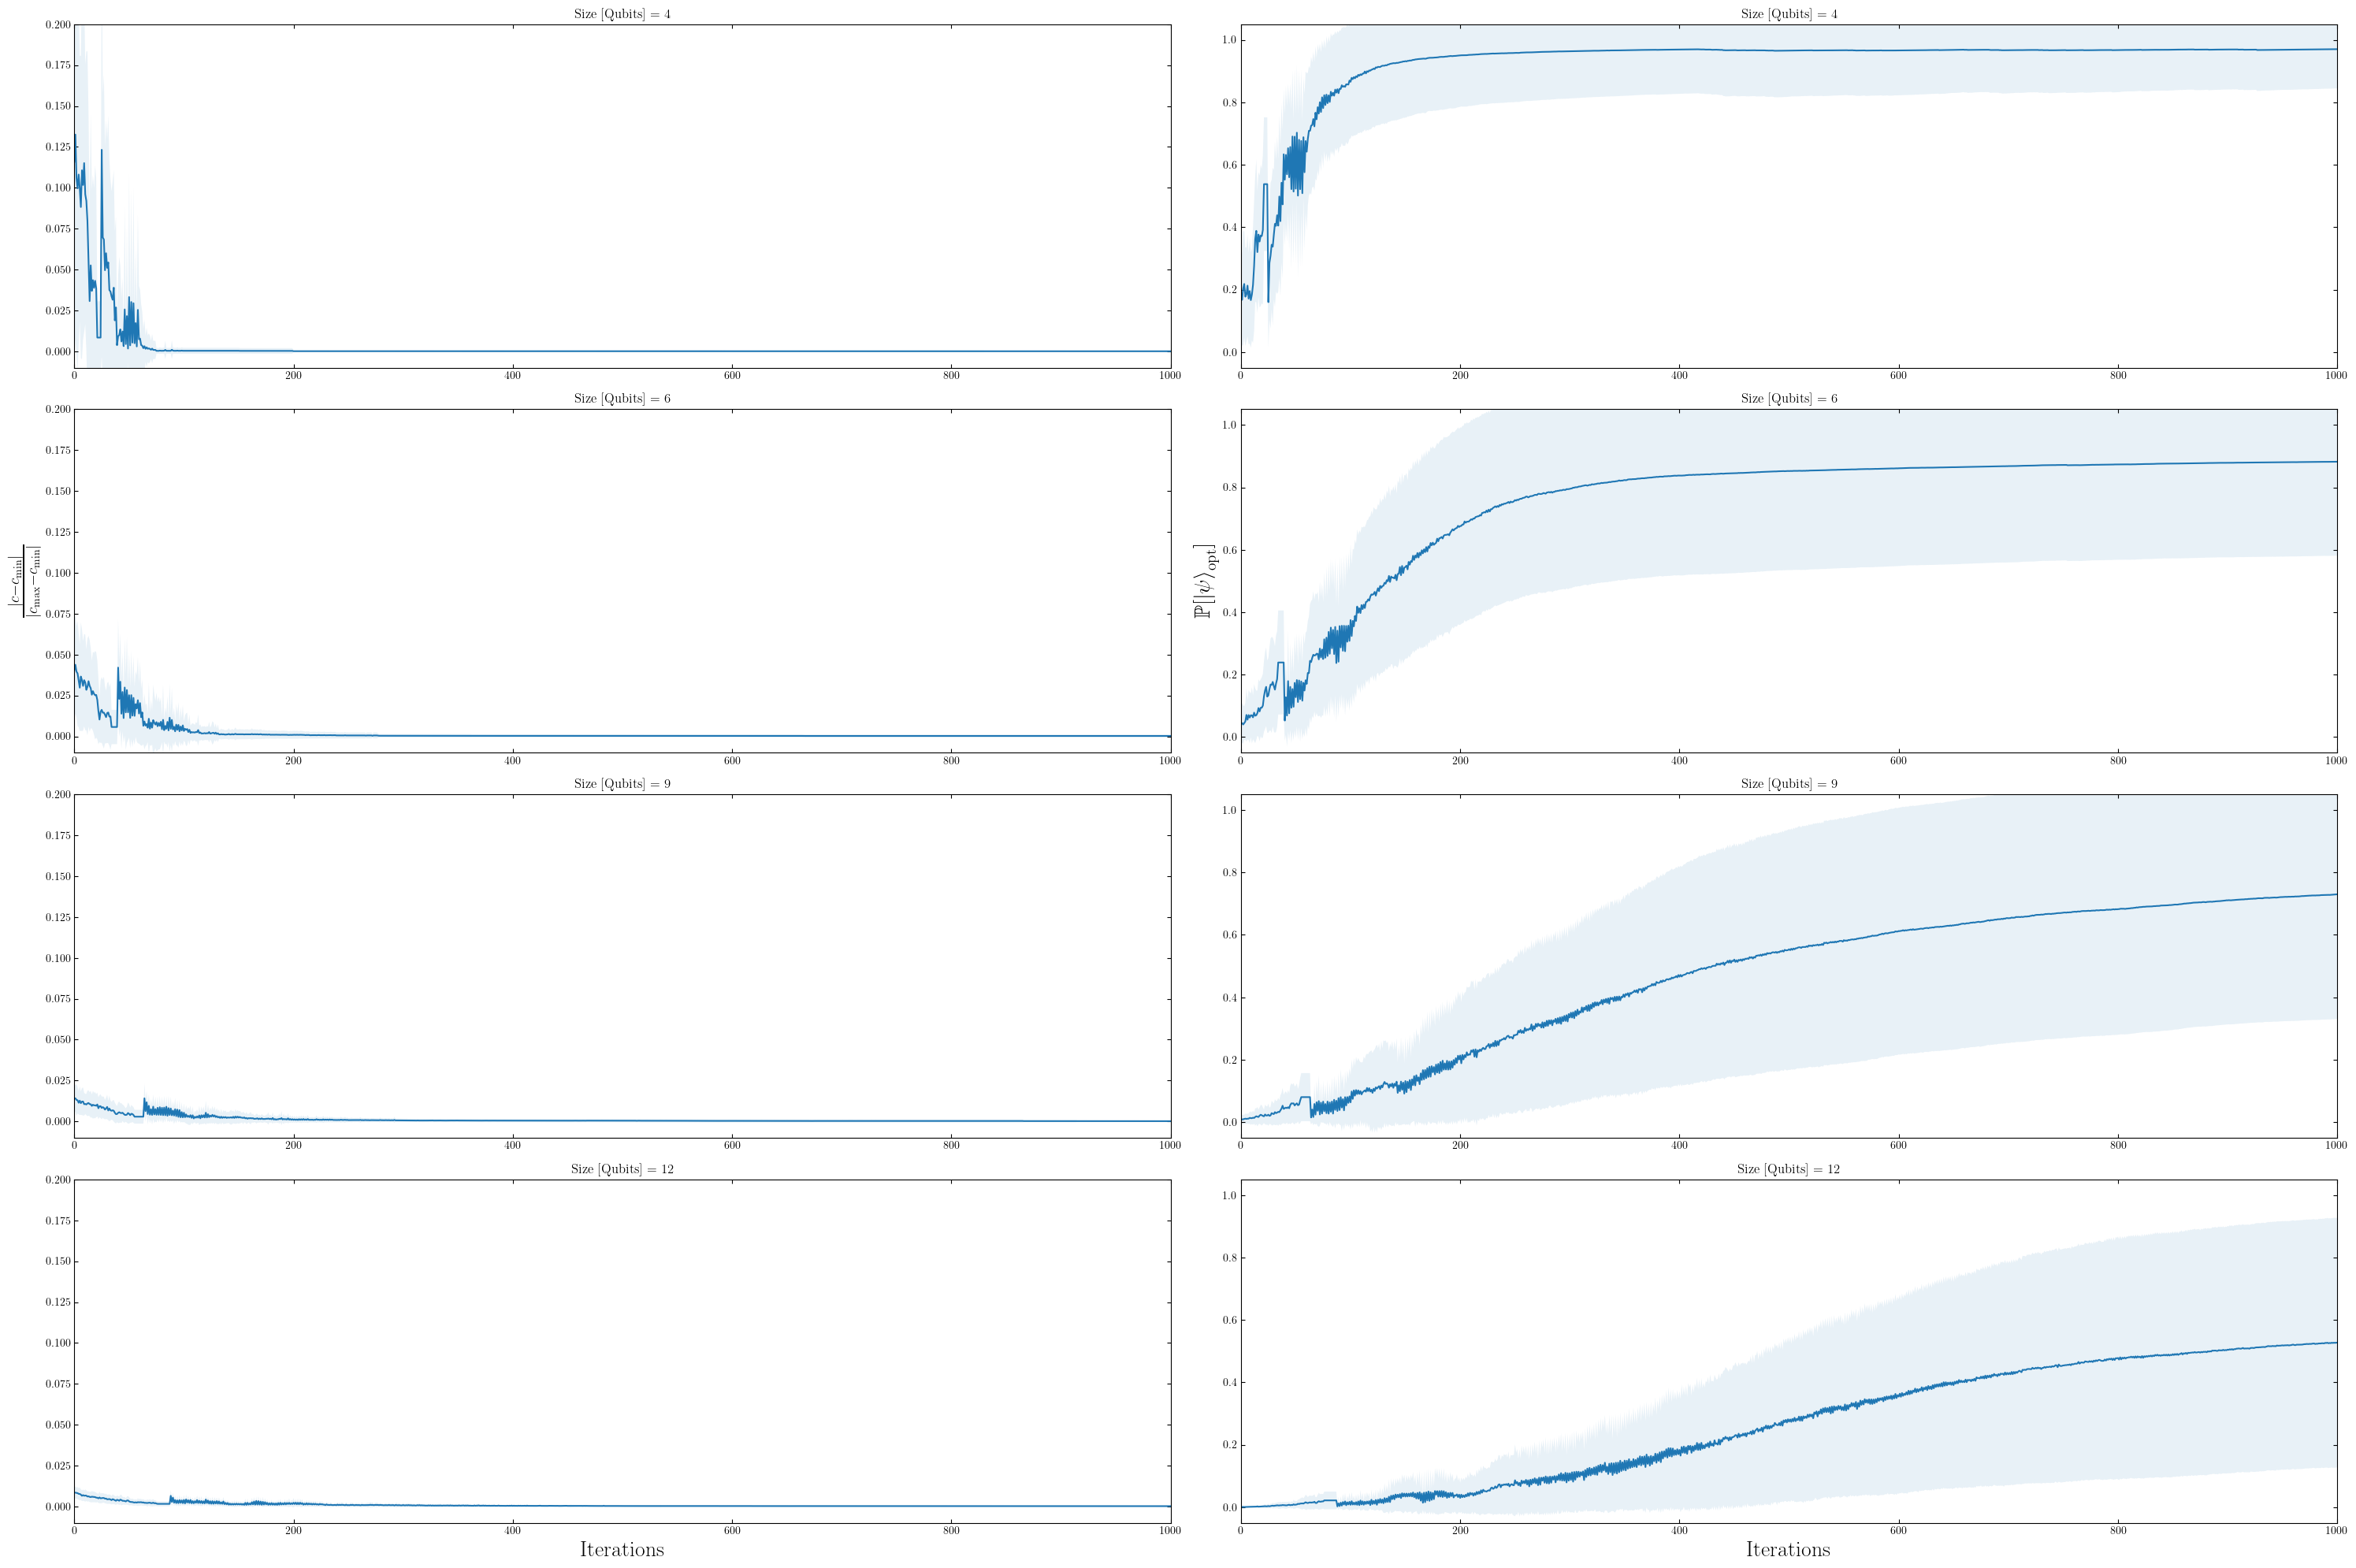

In [17]:
plt.rc("font", family=["Helvetica", "Arial"])
plt.rc("text", usetex=True)
plt.rcParams['text.latex.preamble'] = r'\usepackage{amsmath}\usepackage{amssymb}\usepackage{physics}'
plt.rc("xtick", top=True, direction="in")
plt.rc("ytick", right=True, direction="in")

fig, ax = plt.subplots(len(N_vals),2,figsize=(30,20))

counter = 0
for N in N_vals:
    Y_probs, Y_costs = np.array(result[N]['probs']['CP_VQA_Z_PHASE'][0]), np.array(result[N]['costs']['CP_VQA_Z_PHASE'][0])
    Y_probs_std_dev, Y_costs_std_dev = np.array(result[N]['probs']['CP_VQA_Z_PHASE'][1]), np.array(result[N]['costs']['CP_VQA_Z_PHASE'][1])
    iterations = [it for it in range(len(Y_costs))]
    
    if N == N_vals[1]:
        ax[counter][0].set_ylabel(r'$\frac{|c-c_{\textrm{min}}|}{|c_{\textrm{max}}-c_{\textrm{min}}|}$', fontsize=20)
        ax[counter][1].set_ylabel(r'$\mathbb{P}[\ket{\psi}_{\text{opt}}]$', fontsize=20)
        
    if N == max(N_vals):
        ax[counter][0].set_xlabel(r'Iterations',fontsize=20)
        ax[counter][1].set_xlabel(r'Iterations',fontsize=20)
        
    ax[counter][0].plot(iterations, Y_costs)
    ax[counter][0].fill_between(iterations, Y_costs-Y_costs_std_dev, Y_costs+Y_costs_std_dev, alpha=0.1)
    ax[counter][0].set_title(f'Size [Qubits] = {N}')
    ax[counter][0].set_ylim(-0.01,0.2)
    ax[counter][0].set_xlim(np.min(iterations),np.max(iterations))
    
    
    ax[counter][1].plot(iterations, Y_probs)
    ax[counter][1].fill_between(iterations, Y_probs-Y_probs_std_dev, Y_probs+Y_probs_std_dev, alpha=0.1)
    ax[counter][1].set_title(f'Size [Qubits] = {N}')
    ax[counter][1].set_ylim(-0.05,1.05)
    ax[counter][1].set_xlim(np.min(iterations),np.max(iterations))
    counter += 1


plt.tight_layout()

plt.savefig('../figures/fig_6_part_b.png',dpi=300)